In [1]:
# !git add .
# !git commit -m tolist
# !git push

In [2]:
import sys
sys.path.append('../')

In [3]:
import torch
import torch.nn.functional as F

from utils import experiment, iterate
from nets.mnist import ConvNet

m = ConvNet()
m = m.to('cuda' if torch.cuda.is_available() else 'cpu')

# ckpt = 'checkpoints/ConvNet.pt'
ckpt = '../checkpoints/ConvNet_TRADES.pt'
# ckpt = 'checkpoints/ConvNet_CVaR.pt'

m.load_state_dict({k:torch.load(ckpt)[k] for k in m.state_dict()})



<All keys matched successfully>

In [4]:
with torch.no_grad():
    outputs = iterate.predict(m,
                              iterate.mnist_delta_predict_step_linf,
                              device = 'cuda',
                              val_set = experiment.train_set,
                              batch_size = 1000
                             )
# print(outputs.keys(), outputs['predictions'])


In [5]:
# outputs['predictions'] = torch.tensor(outputs['predictions']).squeeze().tolist()
# outputs['correct'] = torch.tensor(outputs['correct']).squeeze().tolist()

In [6]:
torch.tensor(outputs['samples'][0]).shape

torch.Size([1000, 1, 28, 28])

In [7]:
len(outputs['samples'])

210

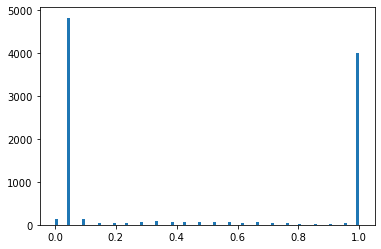

In [8]:
import matplotlib.pyplot as plt

plt.hist(outputs['correct'], bins = 100)
plt.show()

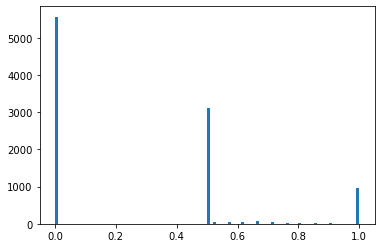

In [9]:
plt.hist(outputs['predictions'], bins = 100)
plt.show()

In [10]:
import numpy as np
from sklearn.neighbors import KDTree


In [11]:
train_X = experiment.train_set.data / 255
train_X = train_X.view(len(train_X), -1).numpy()
train_tree = KDTree(train_X, leaf_size=2)              


In [12]:
test_X = experiment.val_set.data / 255
test_X = test_X.view(len(test_X), -1).numpy()
test_tree = KDTree(test_X, leaf_size=2)              


In [13]:
from tqdm.notebook import trange
all_in = set()
for i in trange(len(train_X)):
    ind = test_tree.query_radius(train_X[i:i+1], r=outputs['predictions'][i])
    all_in.update(set(ind[0].tolist()))
    if len(all_in) == len(test_X):
        break

# ind = tree.query_radius(X[:1], r=0.3)  
# print(ind)  # indices of neighbors within distance 0.3


  0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [92]:
len(all_in)

0

102 34531


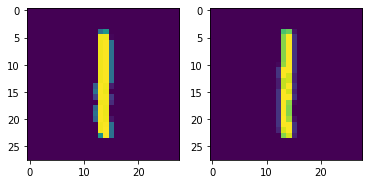

In [121]:
import random

ka = random.randint(0, 60000)
kb = random.randint(0, 60000)
ka = 2730
kb = 17695
ka = 102
kb = 34531
print(ka, kb)
a = experiment.train_set.data[ka].repeat(1, 1, 1, 1) / 255
b = experiment.train_set.data[kb].repeat(1, 1, 1, 1) / 255
la = experiment.train_set.targets[ka]
lb = experiment.train_set.targets[kb]

figure, ax = plt.subplots(1, 2)
ax[0].imshow(a.squeeze())
ax[1].imshow(b.squeeze())
plt.show()
a = a.cuda()
b = b.cuda()




In [76]:
from utils.sampling import sample_uniform_linf_with_clamp, sample_uniform_l2, forward_samples


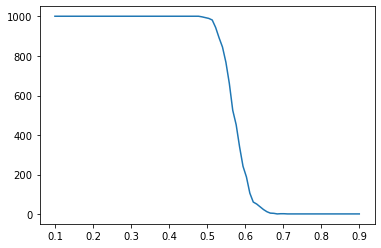

In [87]:
rate_a = []
epsilons = np.linspace(0.1, 0.9, 90)
for eps in epsilons:
    scores_a, inputs_a = forward_samples(m, sample_uniform_linf_with_clamp, a, eps, 1000, batch_size = 10000)
    rate_a.append((scores_a.argmax(-1) == la).sum().item())

plt.plot(epsilons, rate_a)

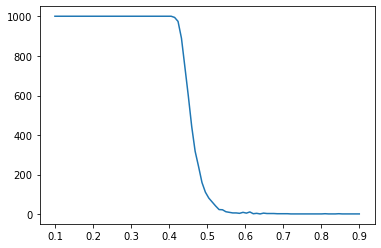

In [90]:
rate_b = []
epsilons = np.linspace(0.1, 0.9, 90)
for eps in epsilons:
    scores_b, inputs_b = forward_samples(m, sample_uniform_linf_with_clamp, b, eps, 1000, batch_size = 10000)
    rate_b.append((scores_b.argmax(-1) == lb).sum().item())

plt.plot(epsilons, rate_b)

In [101]:
mid = (a + b) / 2
eps = torch.where(a > b, a, b) / 2
scores_mid, inputs_mid = forward_samples(m, sample_uniform_linf_with_clamp, mid, eps, 1000, batch_size = 10000)

# rate_mid = []
# epsilons = np.linspace(0.1, 0.9, 90)
# for eps in epsilons:
#     scores_mid, inputs_mid = forward_samples(m, sample_uniform_linf_with_clamp, b, eps, 1000, batch_size = 10000)
#     rate_mid.append((scores_b.argmax(-1) == lb).sum().item())

# plt.plot(epsilons, rate_b)

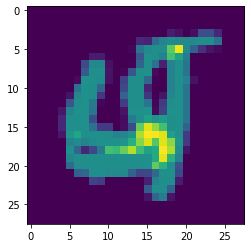

In [99]:
plt.imshow(mid.cpu().squeeze())

(array([ 84.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 474.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  44.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 367.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         27.]),
 array([2.  , 2.07, 2.14, 2.21, 2.28, 2.35, 2.42, 2.49, 2.56, 2.63, 2.7 ,
        2.77, 2.84, 2.91, 2.98, 3.05, 3.12, 3.19, 3.26, 3.33, 3.4 , 3.47,
        3.54, 3.61, 3.68, 3.75, 3.82, 3.89, 3.96, 4.03, 4.1 , 4.17, 4.24,
        4.31, 4.38, 4.45, 4.52, 4.59, 4.66, 4.73, 4.8 , 4.87, 4.94, 5.01,
        5.08, 5.15, 5.

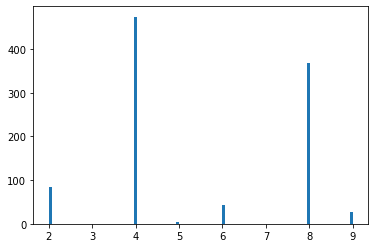

In [107]:
plt.hist(scores_mid.argmax(-1).squeeze().tolist(), bins = 100)

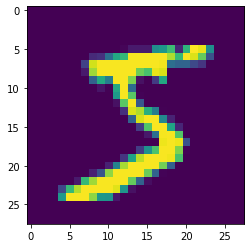

In [118]:
plt.imshow(xj.squeeze())

In [129]:
dt = experiment.train_set.data.view(60000, 1, -1) - experiment.train_set.data.view(1, 60000, -1)
dt.shape

RuntimeError: [enforce fail at alloc_cpu.cpp:66] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 2822400000000 bytes. Error code 12 (Cannot allocate memory)

In [127]:
dt.abs().view(60000, -1).max(-1)

torch.Size([60000, 784, 784])

In [ ]:
min_linf = 1
my_list = []

for i in range(len(experiment.train_set)):
    for j in range(len(experiment.train_set)):
        if i != j:
            xi, li = experiment.train_set[i]
            xj, lj = experiment.train_set[j]
            linf = (xi - xj).abs().max().item()
            if linf < min_linf:
                my_list.append((i, j, linf))
                if li != lj:
                    print(my_list[-1])
                    min_linf = linf

(0, 3, 0.9921568632125854)
(4, 17602, 0.9882352948188782)
(18, 47251, 0.9803921580314636)
(26, 5426, 0.9725490212440491)
(26, 54548, 0.9647058844566345)
(42, 30010, 0.9529411792755127)
(232, 50428, 0.9215686321258545)
